# Spot-checking inicial: Regressão Logística (Multinomial)

## Carregamento dos Dados e Preparação do Ambiente

### Instalação de Pacotes

In [14]:
! pip install pandas numpy matplotlib scikit-learn imbalanced-learn

### Importação de Bibliotecas
Na célula seguinte são importadas bibliotecas e métodos que serão utilizadas repetidamente ao longo da análise.

In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, f1_score,
    ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from utils.visualization import plot_metrics_by_class, print_summary_metrics, print_summary_metrics_latex

/home/max/ML/TrabalhoPraticoML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Definição de Constantes Auxiliares
Na célula seguinte são definidas constantes utilitárias diversas que serão usadas ao longo da análise.

In [2]:
random_state = 42

max_iters = [1000, 2000, 3000, 4000]

configs_to_test = [
    {
    "multi_class":'multinomial',  # Usa softmax
    "solver":'lbfgs',             # Algoritmo de otimização
    "max_iter":max_iter,          # Iterações máximas
    "random_state":random_state,
    "class_weight": "balanced"
    }
    for max_iter in max_iters
]

test_ratio = 0.15

train_ratio_holdout = 0.70
valid_ratio_holdout = 0.15

numeric_attrs = ["idade_paciente", "dias_sintomas_notificacao"]

### Obtenção e análise dos dados
O código abaixo carrega o dataset utilizando as funções do scikit-learn e mostra algumas informações básicas sobre os dados

In [3]:
df_sinan_processed = pd.read_csv("../data/3_gold/dataset-processed.csv")

X = df_sinan_processed.drop("severity", axis=1)
y = df_sinan_processed["severity"]

feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe"]

y = y.map({name: idx for idx, name in enumerate(target_names)})

### Separação do Conjunto de Teste
Essa separação é realizada independentemente do algoritmo utilizado para particionar os dados entre treino e validação (holdout ou LOOCV).

In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state, stratify=y)

### Particionamento dos Dados (Holdout)

In [5]:
# Fazendo a segunda divisão, para gerar o conjunto de treino e validação
final_test_size = valid_ratio_holdout / (train_ratio_holdout + test_ratio)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=final_test_size, random_state=random_state, stratify=y_temp)

# Normalizando atributos numéricos
for col in numeric_attrs:
    mean = X_train[col].mean()
    std = X_train[col].std()
    X_train[col] = (X_train[col] - mean) / (std + 1e-8)
    X_valid[col] = (X_valid[col] - mean) / (std + 1e-8)
    X_test[col] = (X_test[col] - mean) / (std + 1e-8)

print(f"Conjuntos gerados com as seguintes proporções: ")
print(f"  Treinamento: {X_train.shape}")
print(f"  Validação: {X_valid.shape}")
print(f"  Teste: {X_test.shape}")

Conjuntos gerados com as seguintes proporções: 
  Treinamento: (501841, 42)
  Validação: (107538, 42)
  Teste: (107538, 42)


## Amostragem de Dados

### Amostragem com SMOTE

In [6]:
class_counts = Counter(y_train)

print(f"Distribuição original das classes no conjunto de treinamento: {class_counts}")

under_sampler = RandomUnderSampler(sampling_strategy={0: class_counts[1]}, random_state=random_state)
over_sampler = SMOTE(sampling_strategy={2: class_counts[1]}, random_state=random_state)

pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"Distribuição das classes após amostragem no conjunto de treinamento: {Counter(y_train_resampled)}")

Distribuição original das classes no conjunto de treinamento: Counter({0: 294594, 1: 187280, 2: 19967})
Distribuição das classes após amostragem no conjunto de treinamento: Counter({0: 187280, 1: 187280, 2: 187280})


In [7]:
f1_scores_valid = []
f1_scores_train = []

best_config_index = 0
max_f1_valid = 0

for i, config in enumerate(configs_to_test):
  lr = LogisticRegression(**config)
  lr.fit(X_train_resampled, y_train_resampled)

  y_pred = lr.predict(X_valid)
  f1_valid = f1_score(y_valid, y_pred, average='macro', zero_division=0)
  f1_scores_valid.append(f1_valid)

  y_pred_train = lr.predict(X_train)
  f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
  f1_scores_train.append(f1_train)

  max_iter = config["max_iter"]
  print(f"Config: max_iter={max_iter}, F1 validação: {f1_valid:.3f}, F1 treino: {f1_train:.3f}")

  if f1_valid > max_f1_valid:
    max_f1_valid = f1_valid
    best_config_index = i

best_config = configs_to_test[best_config_index]
print(f"\nMelhor configuração: {best_config}, com F1 validação: {max_f1_valid:.3f}")

/home/max/ML/TrabalhoPraticoML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Config: max_iter=1000, F1 validação: 0.460, F1 treino: 0.460


/home/max/ML/TrabalhoPraticoML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Config: max_iter=2000, F1 validação: 0.460, F1 treino: 0.460


/home/max/ML/TrabalhoPraticoML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Config: max_iter=3000, F1 validação: 0.460, F1 treino: 0.460


/home/max/ML/TrabalhoPraticoML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Config: max_iter=4000, F1 validação: 0.460, F1 treino: 0.460

Melhor configuração: {'multi_class': 'multinomial', 'solver': 'lbfgs', 'max_iter': 1000, 'random_state': 42, 'class_weight': 'balanced'}, com F1 validação: 0.460


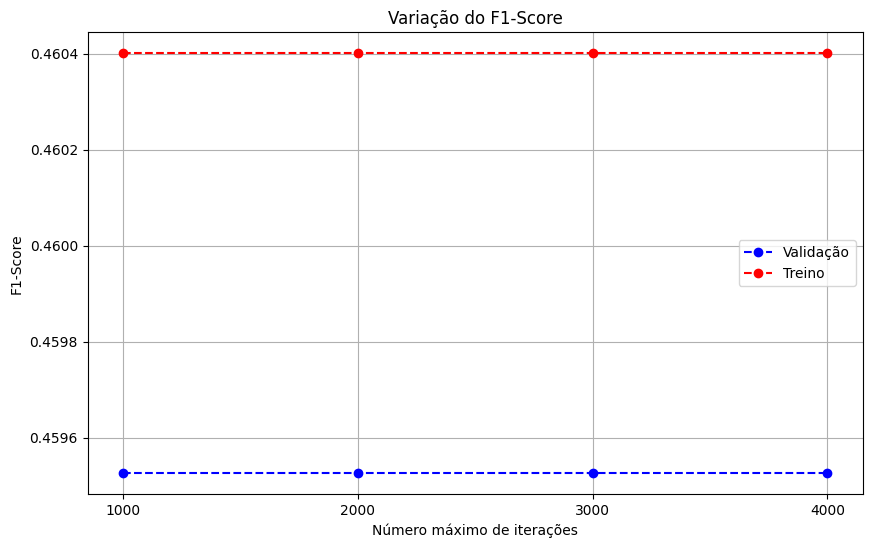

In [9]:
max_iters_as_labels = [str(cfg["max_iter"]) for cfg in configs_to_test]

plt.figure(figsize=(10,6))
plt.plot(max_iters_as_labels, f1_scores_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(max_iters_as_labels, f1_scores_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação do F1-Score')
plt.xlabel('Número máximo de iterações')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

Para avaliarmos o desempenho do modelo otimizado em novos dados, devemos repetir o treinamento selecionando o melhor valor de hiperparâmetro(s) com base no gráfico anterior, e fazer a avaliação nos dados de teste.
Para melhorar a capacidade de estimar o desempenho do modelo, podemos treinar com os dados de treinamento e validação, tendo em vista que ambos são independentes do conjunto de teste (dados nunca vistos).


In [10]:
X_train_full = np.concatenate((X_train, X_valid), axis=0)
y_train_full = np.concatenate((y_train, y_valid), axis=0)

class_counts = Counter(y_train_full)

under_sampler = RandomUnderSampler(sampling_strategy={0: class_counts[1]}, random_state=random_state)
over_sampler = SMOTE(sampling_strategy={2: class_counts[1]}, random_state=random_state)

pipeline = Pipeline([
    ('under', under_sampler),
    ('over', over_sampler)
])

X_train_final, y_train_final = pipeline.fit_resample(X_train_full, y_train_full)

lr = LogisticRegression(**best_config)
lr.fit(X_train_final, y_train_final)

y_pred = lr.predict(X_test)

f1_test = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"F1-Macro (Dados de Teste): {f1_test:.3f}")

/home/max/ML/TrabalhoPraticoML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


F1-Macro (Dados de Teste): 0.462


/home/max/ML/TrabalhoPraticoML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


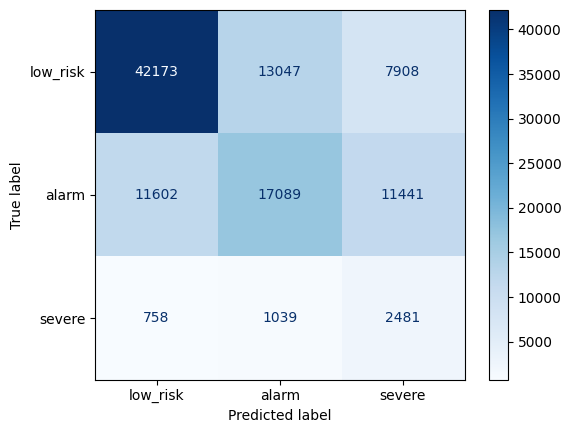

In [11]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)

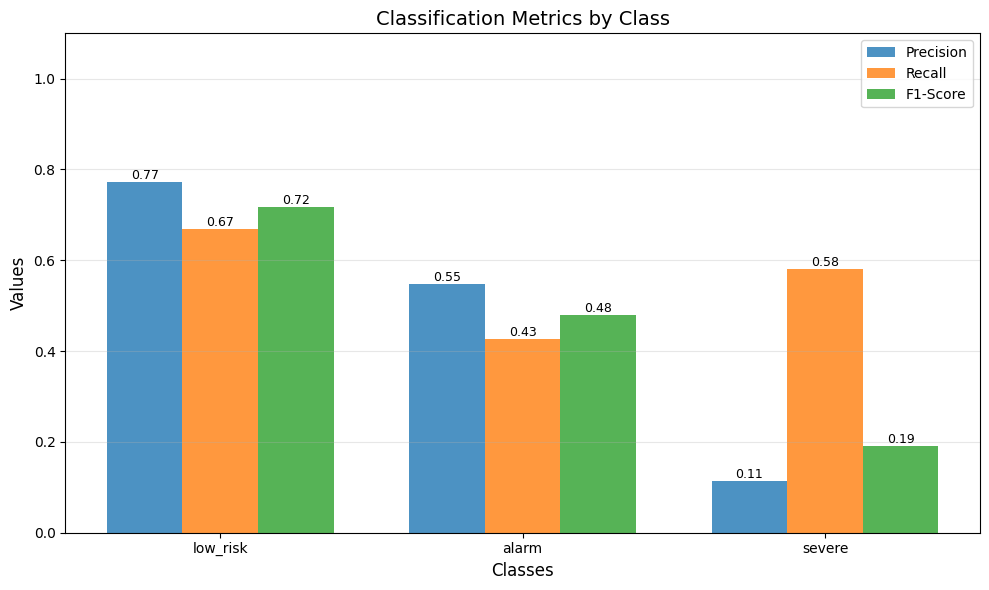

In [15]:
fig, ax, report_dict = plot_metrics_by_class(y_test, y_pred, target_names=target_names)

In [16]:
print_summary_metrics(report_dict)


              CLASSIFICATION METRICS (SUMMARY)              

Accuracy: 0.574

                        Precision       Recall     F1-Score
------------------------------------------------------------
Macro Avg                   0.478        0.558        0.462
Weighted Avg                0.663        0.574        0.607

